In [7]:
import sys
sys.path.append('./gustavos_code/initial')
import seir
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

# To use PyJulia
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main as Julia
Julia.eval('include("la_dança.jl")')

<PyCall.jlwrap fit_initial>

In [8]:
# Configuration
tinc = 2.9
tinf = 5.2
covid_window = int(round(tinc*tinf))
min_days = 5

In [9]:
# Read data and define what are the cities of interest
covid_data = pd.read_csv("/home/pjssilva/nuvem/unicamp/compartilhados/ICMCxCovid/Data/covid_with_cities.csv")
covid_data = covid_data[covid_data["state"] == "SP"]
large_cities = covid_data[covid_data["estimated_population_2019"] > 100000]["city"].unique()

In [10]:
def initial_conditions(city, covid_data, covid_window, min_days, Julia):
    # Gets the city data
    city_data = covid_data[covid_data["city"] == city].copy()
    city_data.reset_index(inplace=True)
    city_data.sort_values(by=["date"], inplace=True)
    population = city_data["estimated_population_2019"].iloc[0]
    confirmed = city_data["confirmed"]

    # I am computing the new cases instead of using the new_confirmed column because
    # there is error at least in the first element for São Paulo. It should be 1.
    new_cases = confirmed.values[1:] - confirmed.values[:-1]
    new_cases = np.append(confirmed[0], new_cases)
    city_data["new_cases"] = new_cases
    
    observed_I = city_data["new_cases"].rolling(covid_window).sum()
    observed_I[:covid_window] = confirmed[:covid_window]
    if len(observed_I) >= min_days:
        observed_I /= population
        Julia.observed_I = observed_I.values
        Julia.eval('initialc = fit_initial(observed_I)')
        S0 = Julia.initialc[0]
        E0 = Julia.initialc[1]
        I0 = Julia.initialc[2]
        R0 = Julia.initialc[3]
        return (S0, E0, I0, R0), observed_I
    else:
        raise ValueError("Not enough data for %s only %d days available" % (city, len(observed_I)))   

In [11]:
%%time

parameters = {}
ignored = []

n_cities = len(large_cities)
for i in range(n_cities):
    c = large_cities[i]
    print("%d/%d" %(i + 1, n_cities), c)
    try:
        parameters[c], observed_I = initial_conditions(c, covid_data, covid_window, min_days, Julia)
    except ValueError:
        print("Ignoring ", c, "not enough data.")
        ignored.append(c)

1/34 Americana
2/34 Araraquara
3/34 Barueri
4/34 Bauru
5/34 Campinas
6/34 Carapicuíba
7/34 Diadema
8/34 Embu Das Artes
9/34 Franca
10/34 Guarujá
11/34 Guarulhos
12/34 Itaquaquecetuba
13/34 Jundiaí
14/34 Limeira
15/34 Marília
16/34 Mauá
17/34 Mogi Das Cruzes
18/34 Osasco
19/34 Piracicaba
20/34 Praia Grande
21/34 Ribeirão Preto
22/34 Santo André
23/34 Santos
24/34 Sorocaba
25/34 Sumaré
Ignoring  Sumaré not enough data.
26/34 Suzano
27/34 São Bernardo Do Campo
28/34 São Carlos
Ignoring  São Carlos not enough data.
29/34 São José Do Rio Preto
30/34 São José Dos Campos
31/34 São Paulo
32/34 São Vicente
33/34 Taboão Da Serra
34/34 Taubaté
CPU times: user 5.04 s, sys: 72.2 ms, total: 5.12 s
Wall time: 5.11 s


Error = 3.763230689521231e-11
Feasibility error = 0.0


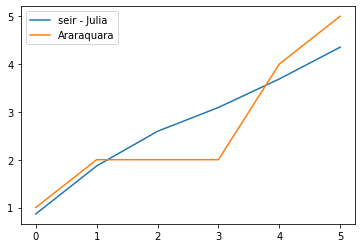

In [12]:
def error(x, y):
    return la.norm(x - y)**2

c = "Araraquara"

city_data = covid_data[covid_data["city"] == c].copy()
city_data.reset_index(inplace=True)
city_data.sort_values(by=["date"], inplace=True)
population = city_data["estimated_population_2019"].iloc[0]
confirmed = city_data["confirmed"]

# I am computing the new cases instead of using the new_confirmed column because
# there is error at least in the first element for São Paulo. It should be 1.
new_cases = confirmed.values[1:] - confirmed.values[:-1]
new_cases = np.append(confirmed[0], new_cases)
city_data["new_cases"] = new_cases

observed_I = city_data["new_cases"].rolling(covid_window).sum()
observed_I[:covid_window] = confirmed[:covid_window]
observed_I /= population
    
ndays = len(observed_I)
S0, E0, I0, R0 = parameters[c]
covid = seir.seir(ndays)
result = covid.run((S0,E0,I0,R0))
    
plt.plot(np.arange(ndays), population*result[2,:], label='seir - Julia')
plt.plot(np.arange(ndays), population*observed_I.values, label=c)
plt.legend()
print("Error =", error(result[2,:], observed_I))
print("Feasibility error =", np.abs(1.0 - np.array((S0, E0, I0, R0)).sum()))